In [132]:
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [133]:
path_gene_h5ad = "/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Huangfu_HUES8-embryonic-stemcell-differentiation_TF-Perturb-seq/Transcriptome_Analysis/anndata.h5ad"
path_guide_h5ad = "/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Huangfu_HUES8-embryonic-stemcell-differentiation_TF-Perturb-seq/Perturbation_information/guide_assignment_matrix.h5ad"

In [134]:
gene = sc.read_h5ad(path_gene_h5ad)
gene

AnnData object with n_obs × n_vars = 132584 × 38606
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

In [135]:
guide = sc.read_h5ad(path_guide_h5ad)
guide

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 95717 × 13160
    var: 'protospacer_ID', 'protospacer', 'intended_target_name', 'type', 'genomic_element', 'reverse_compliment', 'protospacer_upper', 'Huangfu_id', 'Huangfu_name'

# Number of sequencing lanes

In [136]:
#
gene.obs["barcode"] = gene.obs.index.str.split("-").str[0]
gene.obs["lane"] = gene.obs.index.str.split("-").str[1]
gene.obs["lane"].value_counts()

lane
8    17977
2    17013
6    17001
1    16929
4    16838
7    16185
5    15482
3    15159
Name: count, dtype: int64

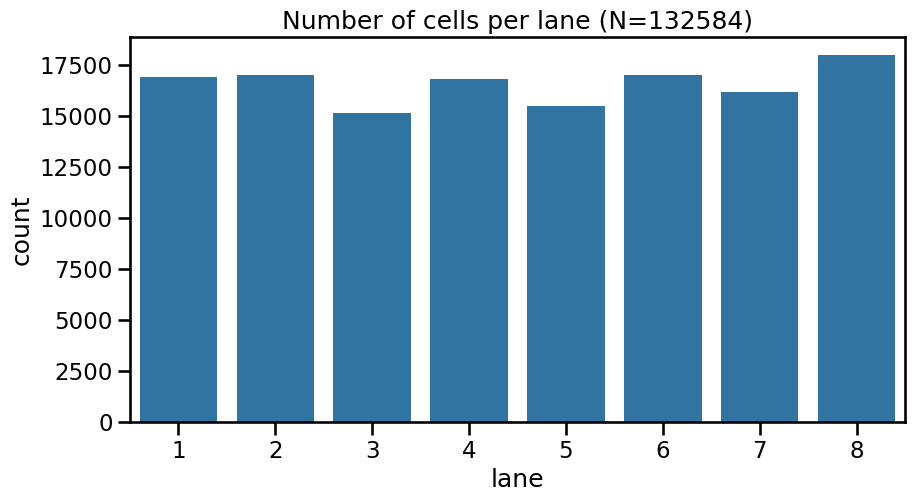

In [137]:
# Plot the number of cells per lane
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.countplot(x="lane", data=gene.obs, ax=ax)
    ax.set_title(f"Number of cells per lane (N={gene.n_obs})")
    plt.show()

# Transcriptome

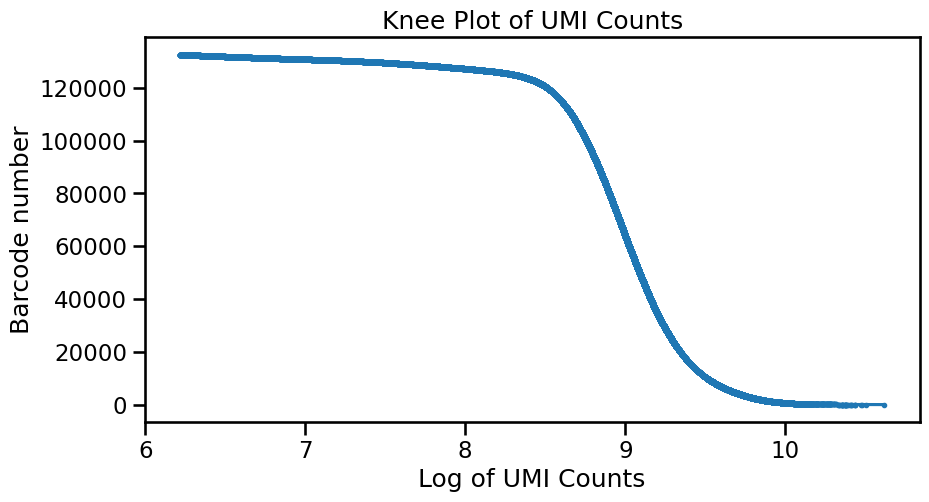

In [138]:
# # Knee plot of UMI count (x-axis) vs. barcode rank
knee_df = pd.DataFrame({
    'sum': np.array(gene.X.sum(1)).flatten(),
    'barcodes': gene.obs_names.values
})
knee_df = knee_df.sort_values('sum', ascending=False).reset_index(drop=True)
knee_df['sum_log'] = np.log1p(knee_df['sum'])
with sns.plotting_context("talk"):
    plt.figure(figsize=(10, 5))
    plt.plot(knee_df['sum_log'], knee_df.index, marker='o', linestyle='-', markersize=3)
    plt.ylabel('Barcode number')
    plt.xlabel('Log of UMI Counts')
    plt.title('Knee Plot of UMI Counts')

In [139]:
gene.var["MT"] = gene.var_names.str.startswith("MT-")
gene.var["RIBO"] = gene.var_names.str.startswith(("RPS", "RPL"))
sc.pp.calculate_qc_metrics(gene, qc_vars=["MT", "RIBO"], inplace=True, log1p=True)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this 

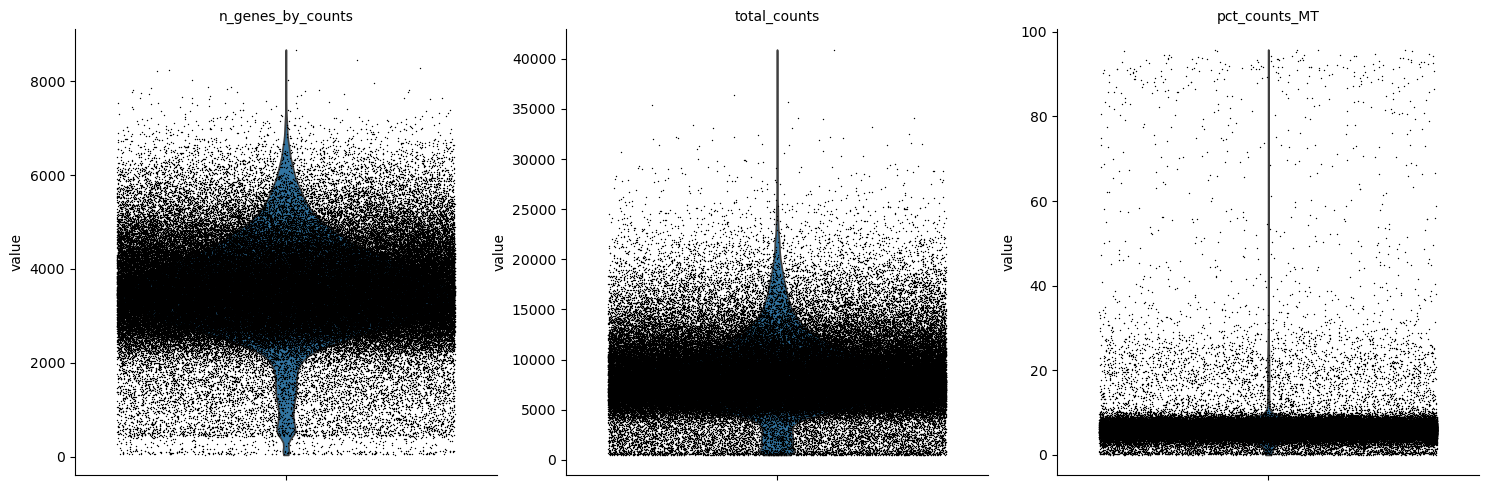

In [140]:
sc.pl.violin(
    gene,
    ["n_genes_by_counts", "total_counts", "pct_counts_MT"],
    jitter=0.4,
    multi_panel=True,
)

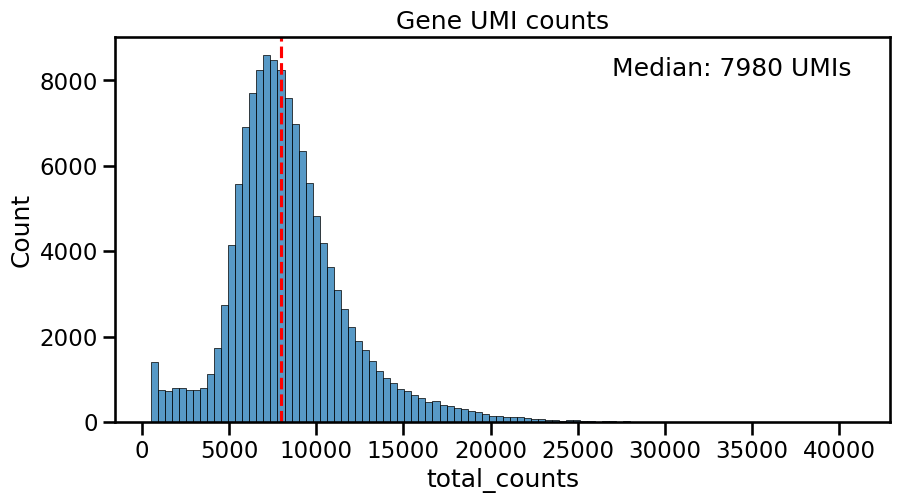

In [141]:
# Plot the distribution of UMI counts and annotate with median (red dashed line and text in upper right corner)
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(gene.obs["total_counts"], bins=100, ax=ax)
    ax.axvline(gene.obs["total_counts"].median(), color="red", linestyle="--")
    ax.text(0.95, 0.95, f"Median: {gene.obs['total_counts'].median():.0f} UMIs", ha="right", va="top", transform=ax.transAxes)
    ax.set_title("Gene UMI counts")
    plt.show()

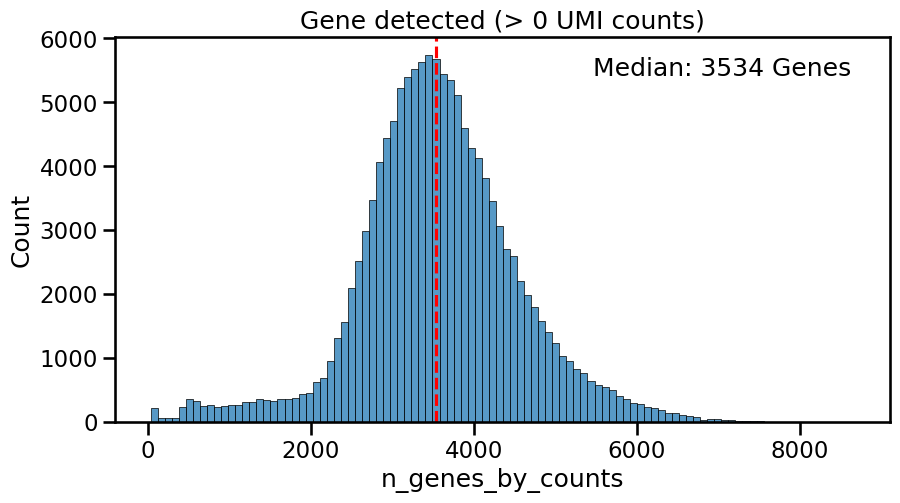

In [142]:
# Plot the distribution of UMI counts and annotate with median (red dashed line and text in upper right corner)
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(gene.obs["n_genes_by_counts"], bins=100, ax=ax)
    ax.axvline(gene.obs["n_genes_by_counts"].median(), color="red", linestyle="--")
    ax.text(0.95, 0.95, f"Median: {gene.obs['n_genes_by_counts'].median():.0f} Genes", ha="right", va="top", transform=ax.transAxes)
    ax.set_title("Gene detected (> 0 UMI counts)")
    plt.show()

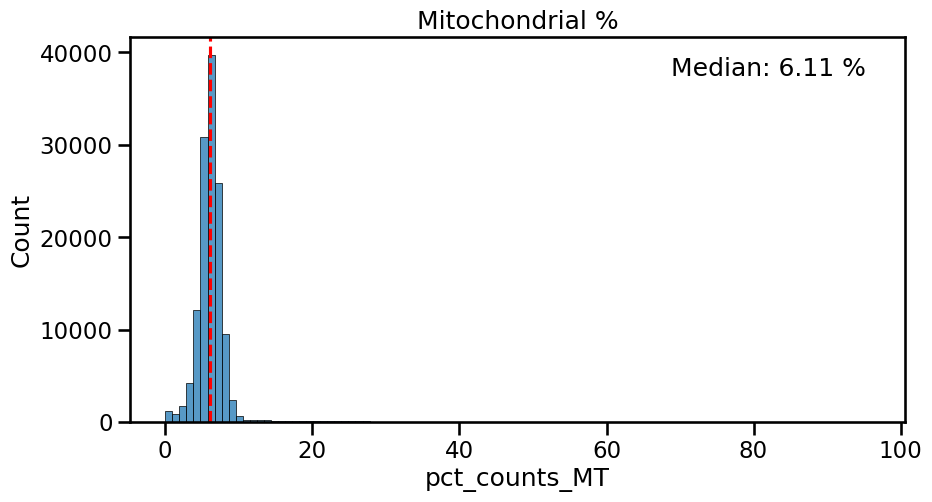

In [143]:
# Plot the distribution of MT % and annotate with median (red dashed line and text in upper right corner)
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(gene.obs["pct_counts_MT"], bins=100, ax=ax)
    ax.axvline(gene.obs["pct_counts_MT"].median(), color="red", linestyle="--")
    ax.text(0.95, 0.95, f"Median: {gene.obs['pct_counts_MT'].median():.2f} %", ha="right", va="top", transform=ax.transAxes)
    ax.set_title("Mitochondrial %")
    plt.show()

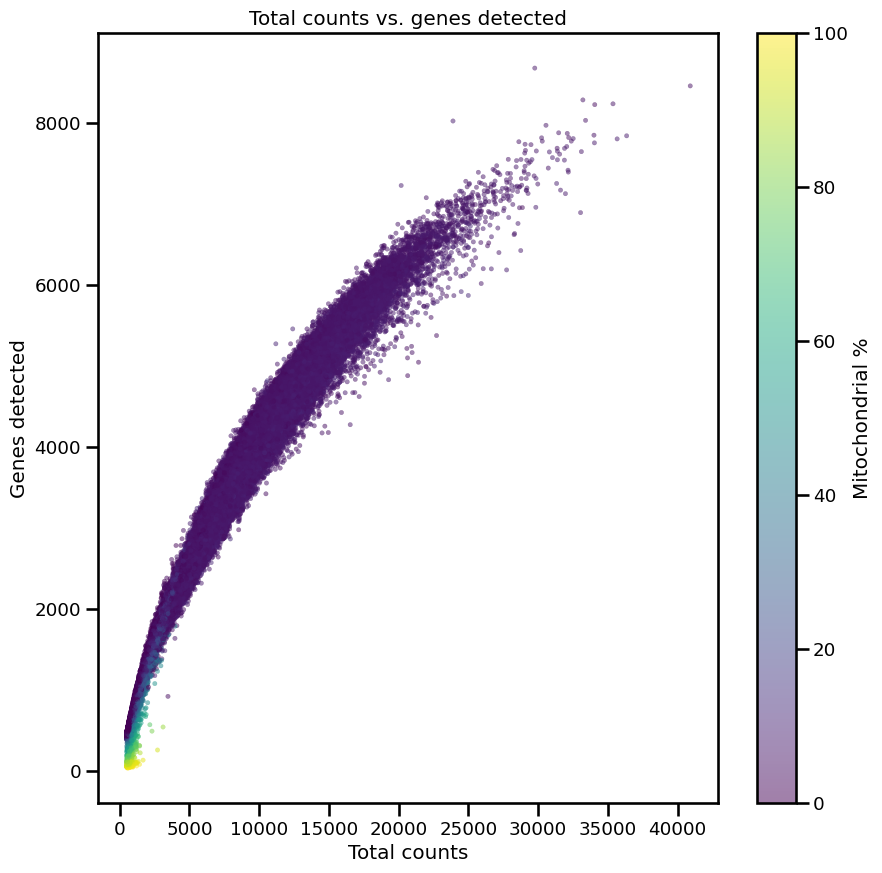

In [144]:
# Scatterplot of total counts vs. genes detected, colored by mitochondrial content (viridis continuous color map)
with sns.plotting_context("talk", font_scale=0.8):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(x="total_counts", y="n_genes_by_counts", hue="pct_counts_MT", data=gene.obs, ax=ax, alpha=0.5, s=10, palette="viridis", edgecolor=None)
    ax.get_legend().remove()
    plt.colorbar(ax.collections[0], ax=ax, label="Mitochondrial %")
    ax.collections[0].set_clim(0, 100)
    ax.set_xlabel("Total counts")
    ax.set_ylabel("Genes detected")
    ax.set_title("Total counts vs. genes detected")
    plt.show()

In [145]:
# filter for mic_cells and min_genes
sc.pp.filter_cells(gene, min_genes=500)
sc.pp.filter_genes(gene, min_cells=3)

In [146]:
# filter for percent mito
gene = gene[gene.obs['pct_counts_MT'] < 20, :]

In [147]:
gene

View of AnnData object with n_obs × n_vars = 130449 × 34060
    obs: 'barcode', 'lane', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'total_counts_RIBO', 'log1p_total_counts_RIBO', 'pct_counts_RIBO', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'MT', 'RIBO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

# Guide 

In [148]:
sc.pp.calculate_qc_metrics(guide, inplace=True, log1p=True, var_type="guides")

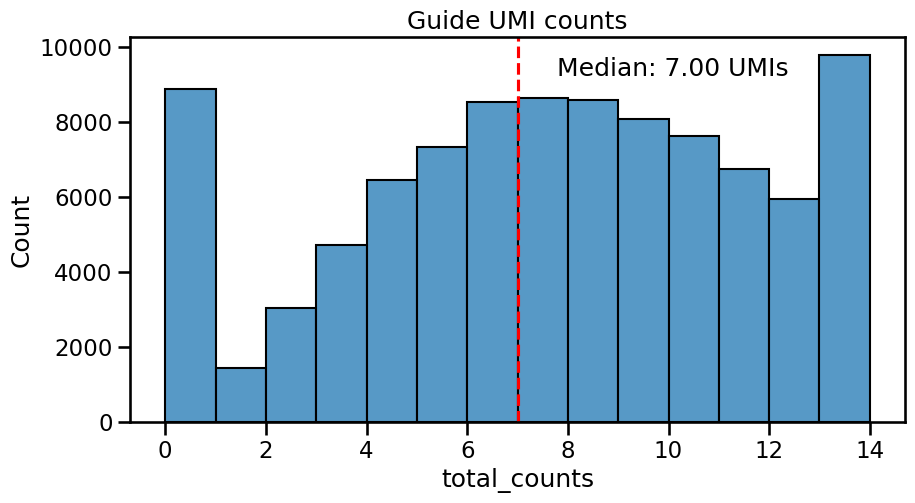

In [149]:
# Plot the distribution of UMI counts and annotate with median (red dashed line and text in upper right corner)
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(guide.obs["total_counts"],bins=14, ax=ax)
    ax.axvline(guide.obs["total_counts"].median(), color="red", linestyle="--")
    ax.text(0.85, 0.95, f"Median: {guide.obs['total_counts'].median():.2f} UMIs", ha="right", va="top", transform=ax.transAxes)
    ax.set_title("Guide UMI counts")
    plt.show()

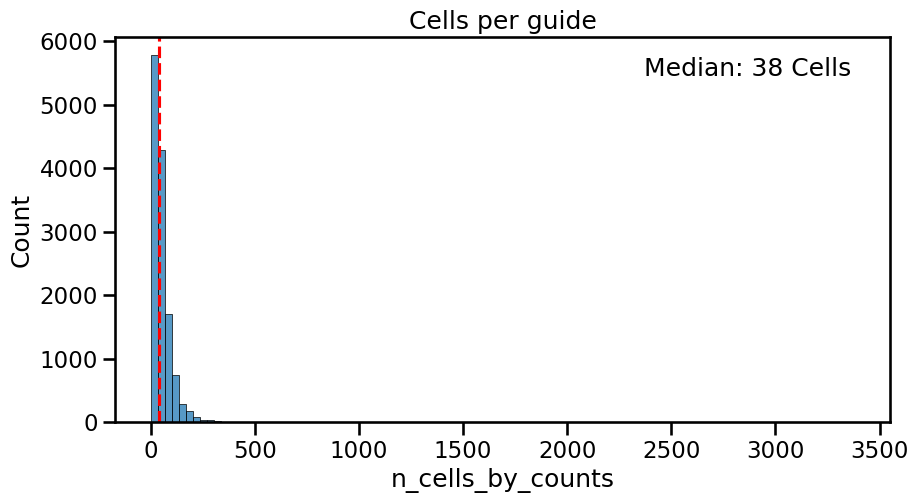

In [150]:
# Plot the distribution of cells per guide and annotate with median (red dashed line and text in upper right corner)
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(guide.var["n_cells_by_counts"], bins=100, ax=ax)
    ax.axvline(guide.var["n_cells_by_counts"].median(), color="red", linestyle="--")
    ax.text(0.95, 0.95, f"Median: {guide.var['n_cells_by_counts'].median():.0f} Cells", ha="right", va="top", transform=ax.transAxes)
    ax.set_title("Cells per guide")

In [154]:
# How many guides have zero detected cells?
(guide.var["n_cells_by_counts"] == 0).sum()

69

In [155]:
# How many cells have zero detected guides?
(guide.obs["n_guides_by_counts"] == 0).sum()

8857

In [156]:
np.max(guide.X)

1

# Singlet detection (if performed)

In [129]:
sc.pp.scrublet?

Signature:
sc.pp.scrublet(
    adata: 'AnnData',
    adata_sim: 'AnnData | None' = None,
    *,
    batch_key: 'str | None' = None,
    sim_doublet_ratio: 'float' = 2.0,
    expected_doublet_rate: 'float' = 0.05,
    stdev_doublet_rate: 'float' = 0.02,
    synthetic_doublet_umi_subsampling: 'float' = 1.0,
    knn_dist_metric: '_Metric | _MetricFn' = 'euclidean',
    normalize_variance: 'bool' = True,
    log_transform: 'bool' = False,
    mean_center: 'bool' = True,
    n_prin_comps: 'int' = 30,
    use_approx_neighbors: 'bool | None' = None,
    get_doublet_neighbor_parents: 'bool' = False,
    n_neighbors: 'int | None' = None,
    threshold: 'float | None' = None,
    verbose: 'bool' = True,
    copy: 'bool' = False,
    random_state: 'AnyRandom' = 0,
) -> 'AnnData | None'
Docstring:
Predict doublets using Scrublet :cite:p:`Wolock2019`.

Predict cell doublets using a nearest-neighbor classifier of observed
transcriptomes and simulated doublets. Works best if the input is a raw
(unnor

# Number of cells per target

In [159]:
var_df = guide.var

In [172]:
var_df["type"].value_counts()

type
targeting    13160
Name: count, dtype: int64

In [169]:
# Aggregate the guide information to the gene level (intended_target_name)
target_df = var_df.groupby("intended_target_name").agg(
    n_cells_per_guide=("n_cells_by_counts", "sum"),
    type=("type", "first"),
    guides=("protospacer_ID", lambda x: x.unique().tolist()),
)

/tmp/ipykernel_3321433/3652798259.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_df = var_df.groupby("intended_target_name").agg(


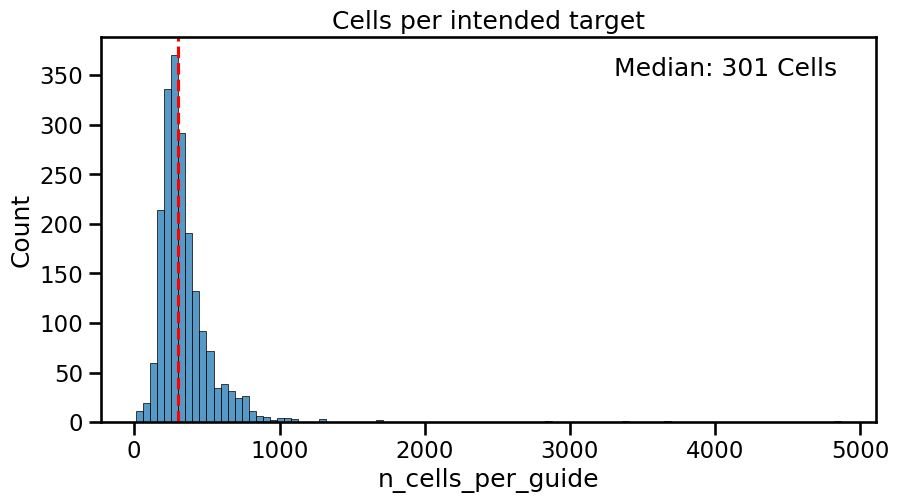

In [170]:
# Plot the distribution of cells per guide and annotate with median (red dashed line and text in upper right corner)
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(target_df["n_cells_per_guide"], bins=100, ax=ax)
    ax.axvline(target_df["n_cells_per_guide"].median(), color="red", linestyle="--")
    ax.text(0.95, 0.95, f"Median: {target_df['n_cells_per_guide'].median():.0f} Cells", ha="right", va="top", transform=ax.transAxes)
    ax.set_title("Cells per intended target")

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


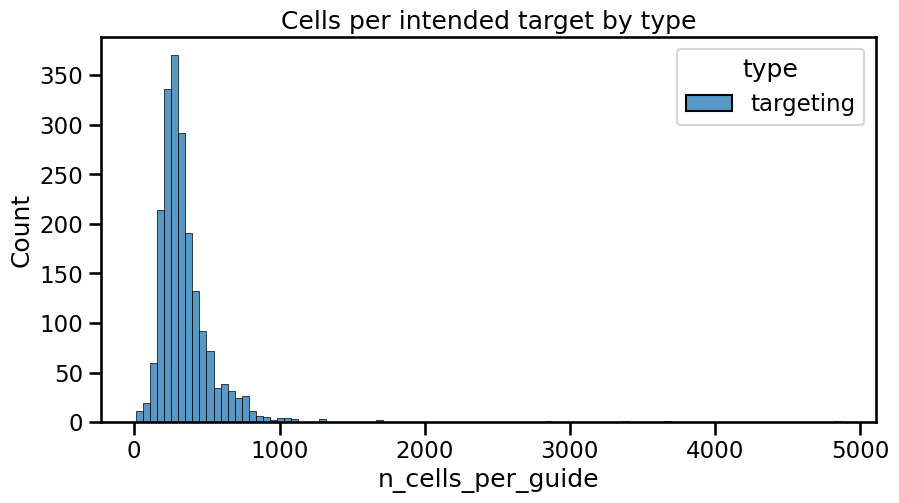

In [171]:
# Group the intended targets by type and plot the distribution of cells per guide
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(target_df, x="n_cells_per_guide", hue="type", bins=100, multiple="stack", ax=ax)
    ax.set_title("Cells per intended target by type")

In [166]:
target_df.sort_values("n_cells_per_guide", ascending=False)

,n_cells_per_guide
intended_target_name,
CD81,4863
DNAJC19,3697
CD29,3383
CD151,2868
ESRRG,1699
...,...
HINFP,38
ATF5,28
TAF1A,26


# Number of cells per sgRNA